In [184]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Лабораторная работа 1 "Градиентный спуск и его модификации"
Выполнил студент группы М8О-114СВ-24, Терентьев И.В.

<ul>
    <li><big>В ходе лабораторной работы реализован классический вариант алгоритма градиентного спуска, моментная модификация и адаптивная модификация AdaGrad</big></li>
    <li><big>Градиент функции в точке находится численным методом, символьным методом, а также функцией от пользователя</big></li>
<li><big>Реализована визуализация графика функции и найденной точки оптимума</big></li>
<li><big>Реализовано нахождение погрешности найденного решения в сравнении с аналитическим, протестировано для разных модификаций и методов вычисления градиента</big></li>
</ul>


<p><big>Инструменты</big></p>

In [185]:
def plot_function_2D(f, x_range, y_range, optimum):
    x = np.linspace(x_range[0], x_range[1], 400)
    y = np.linspace(y_range[0], y_range[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = f([X, Y])

    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar()
    plt.scatter(optimum[0], optimum[1], color='red', label='Оптимум')
    plt.title('Визуализация функции')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [186]:
def plot_function_3D(f, optimum):
    X_mesh, Y_mesh = np.meshgrid([i for i in np.arange(-15, 15, 0.1)], [i for i in np.arange(-15, 15, 0.1)])
    Z_mesh = f([X_mesh, Y_mesh])
    
    plt.rcParams.update({
    'figure.figsize': (4, 4),
    'figure.dpi': 200,
    'xtick.labelsize': 4,
    'ytick.labelsize': 4
    })
    ax = plt.figure().add_subplot(111, projection='3d')
    ax.scatter([optimum[0]], [optimum[1]], [f(optimum)], color='red')
        
    ax.plot_surface(X_mesh, Y_mesh, Z_mesh, rstride=5, cstride=5, alpha=0.5)
        
    ax.scatter([optimum[0]], [optimum[1]], [f(optimum)], color='blue')
        
    ax.view_init(30, -130)
        
    plt.show()

In [187]:
def numerical_gradient(func, X, h=1e-5):
        grad = np.zeros_like(X)
        for i in range(X.size):
            X_inc = X.copy()
            X_inc[i] += h
            X_dec = X.copy()
            X_dec[i] -= h
            grad[i] = (func(X_inc) - func(X_dec)) / (2*h)
        return grad

In [188]:
def num_grad_func(func):
    """Декоратор для вычисления численного градиента функции."""
    def grad_func(*args):
        result = numerical_gradient(func, *args)
        return result

    return grad_func

In [228]:
def sym_grad_func(func):
    """Декоратор для вычисления символьного градиента функции."""
    def wrapper(X, *args):
        
        x, y = sp.symbols('x y')
        
        function_expression = func([x, y])
        
        gradient = [sp.diff(function_expression, var) for var in (x, y)]
        
        numeric_grad = [float(g.subs({x: X[0], y: X[1]})) for g in gradient]
        
        return np.array(numeric_grad)

    return wrapper

In [231]:
def count_err(minimum, true_minimum):
    return np.linalg.norm(minimum - true_minimum)

<h3>Классический градиентный спуск</h3>

In [191]:
class GradientDescent:
    def __init__(self, function, err_func, gradient, learning_rate=0.1, max_iter=5000, tol=1e-6):
        self.function = function
        self.err_func = err_func
        self.gradient = gradient
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
    
    def optimize(self, initial_point):
        point = np.array(initial_point, dtype=float)
        for i in range(self.max_iter):
            grad = self.gradient(point)
            new_point = point - self.learning_rate * grad

            # Проверка на сходимость
            if self.err_func(new_point, point) < self.tol:
                break
            
            point = new_point
        return point

<h3>Моментная модификация</h3>

In [192]:
class MomentumGradientDescent(GradientDescent):
    def __init__(self, function, err_func, gradient, learning_rate=0.1, momentum=0.9, max_iter=5000, tol=1e-6):
        super().__init__(function, err_func, gradient, learning_rate, max_iter, tol)
        self.momentum = momentum
        self.velocity = np.zeros(2)

    def optimize(self, initial_point):
        point = np.array(initial_point, dtype=float)
        for i in range(self.max_iter):
            grad = self.gradient(point)
            self.velocity = self.momentum*self.velocity - self.learning_rate*self.gradient(point)
            new_point = point + self.velocity
            
            if self.err_func(new_point, point) < self.tol:
                break
            
            point = new_point
        
        return point

<h3>Адаптивная модификация</h3>

In [193]:
class AdaGrad(GradientDescent):
    def __init__(self, function, err_func, gradient, learning_rate=0.1, max_iter=5000, tol=1e-6):
        super().__init__(function, err_func, gradient, learning_rate, max_iter, tol)
        self.eps = 1e-8
        self.grad_squared = np.zeros(2)

    def optimize(self, initial_point):
        point = np.array(initial_point, dtype=float)
        for i in range(self.max_iter):
            grad = self.gradient(point)
            self.grad_squared += np.square(grad)
            adjusted_lr = self.learning_rate / (np.sqrt(self.grad_squared) + self.eps)
            new_point = point - adjusted_lr * grad
            
            if self.err_func(new_point, point) < self.tol:
                break
            
            point = new_point
        
        return point

<p><big>Пайплайн</big></p>

In [241]:
# Функция пайплайн для тестирования
def pipeline(optimizer_class, initial_point, true_minimum, function, err_func, gradient, is_show_plot=True):
    print(f"Тестирование {optimizer_class.__name__}...")
    
    # Инициализация оптимизатора
    optimizer = optimizer_class(function, err_func, gradient)
    
    # Оптимизация
    minimum = optimizer.optimize(initial_point)
    
    # Вычисление погрешности
    error = count_err(minimum, true_minimum)
    print(f"Найденный минимум: {minimum}, Ошибка: {error}")
    
    # Визуализация
    if is_show_plot:
        plot_function_2D(function, [-5, 5], [-5, 5], minimum)
        plot_function_3D(function, minimum)

<h2>Тестирование</h2>

In [242]:
# Определение тестовых функций
# Тестовая функция сферы
def test_function_1(X):
    return np.square(X[0]) + np.square(X[1])

num_test_gradient_1 = num_grad_func(test_function_1) 
sym_test_gradient_1 = sym_grad_func(test_function_1) 
    
# Тестовая функция Матьяса
def test_function_2(X):
    return 0.26*(np.square(X[0]) + np.square(X[1])) - 0.48*X[0]*X[1]
    
num_test_gradient_2 = num_grad_func(test_function_2) 
sym_test_gradient_2 = sym_grad_func(test_function_2) 

<p><big>Для каждой модификации алгоритма построен график найденного оптимума с численно вычисленным градиентом и выведена ошибка, а также выведена ошибки для найденного символьным методом градиента</big></p>

<h3>Оптимизация функции сферы</h2>

Тестирование GradientDescent...
Найденный минимум: [3.92318858e-06 2.35391315e-06], Ошибка: 4.575184782261214e-06
Тестирование GradientDescent...
Найденный минимум: [3.92318858e-06 2.35391315e-06], Ошибка: 4.575184782273924e-06


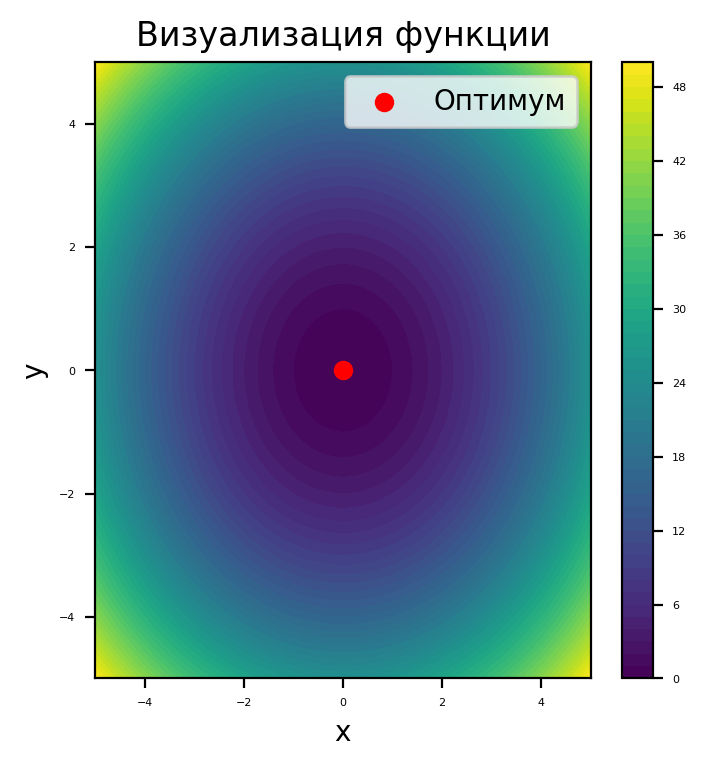

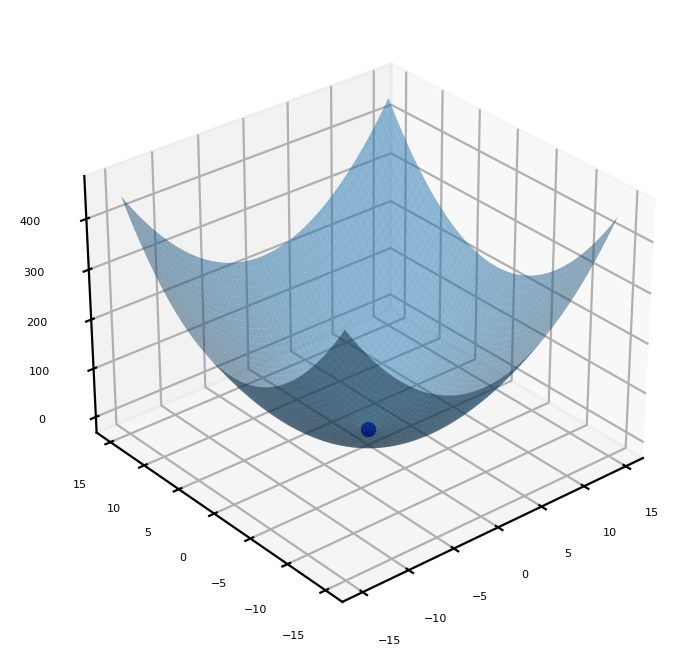

In [243]:
true_minimum_1 = np.array([0, 0])
initial_point = [5, 3]

pipeline(GradientDescent, initial_point, true_minimum_1, test_function_1, count_err, sym_test_gradient_1, False)
pipeline(GradientDescent, initial_point, true_minimum_1, test_function_1, count_err, num_test_gradient_1)

Тестирование MomentumGradientDescent...
Найденный минимум: [-1.47913782e-04 -8.87482691e-05], Ошибка: 0.0001724956293861262
Тестирование MomentumGradientDescent...
Найденный минимум: [-1.47913782e-04 -8.87482692e-05], Ошибка: 0.0001724956293873309


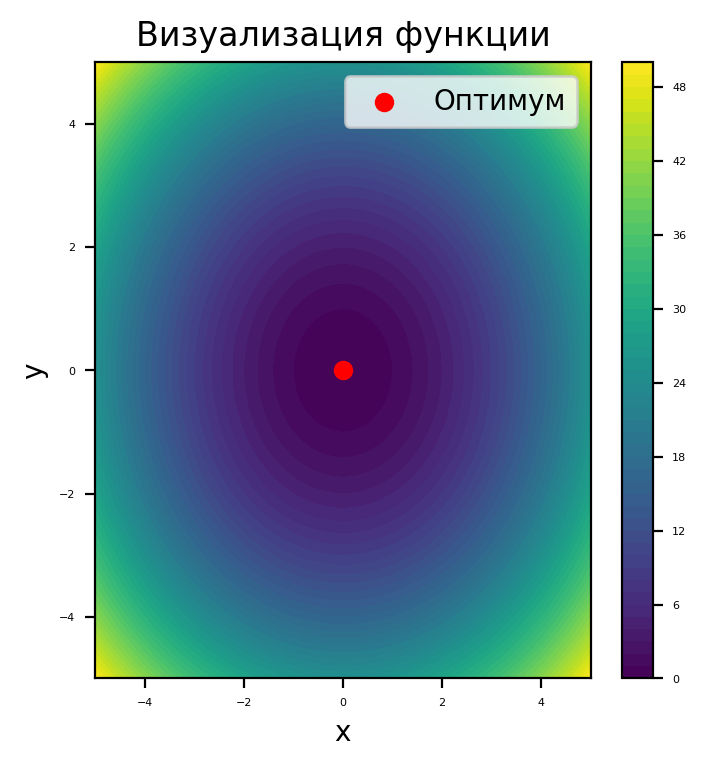

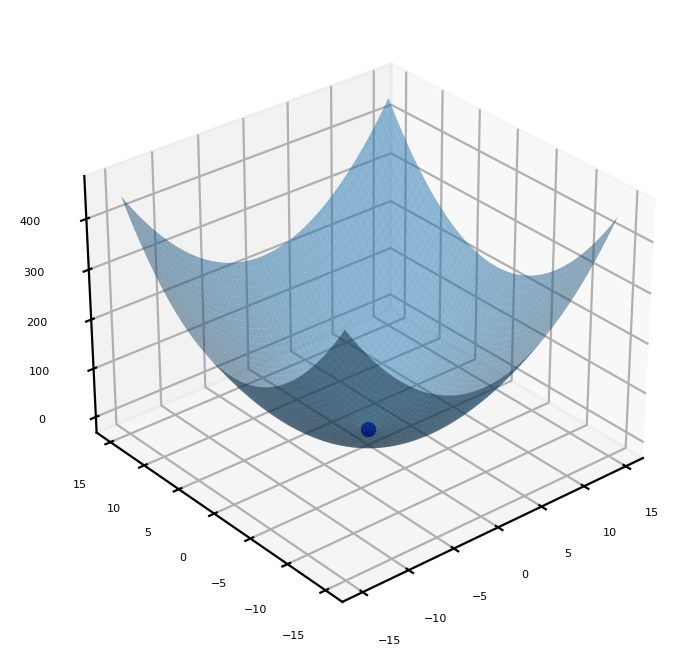

In [245]:
pipeline(MomentumGradientDescent, initial_point, true_minimum_1, test_function_1, count_err, sym_test_gradient_1, False)
pipeline(MomentumGradientDescent, initial_point, true_minimum_1, test_function_1, count_err, num_test_gradient_1)

Тестирование AdaGrad...
Найденный минимум: [1.59177312e-03 2.67501603e-09], Ошибка: 0.0015917731152581978
Тестирование AdaGrad...
Найденный минимум: [1.59177312e-03 2.67501603e-09], Ошибка: 0.001591773115129107


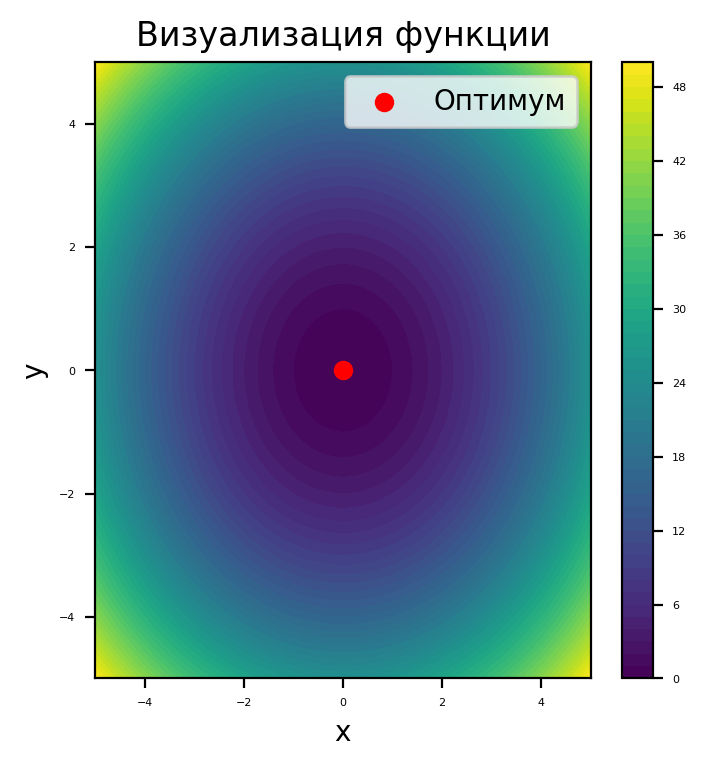

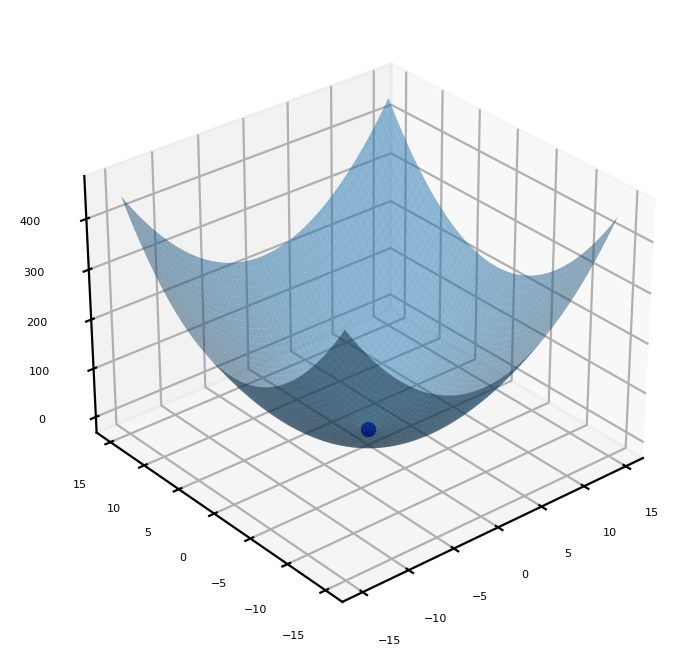

In [246]:
pipeline(AdaGrad, initial_point, true_minimum_1, test_function_1, count_err, sym_test_gradient_1, False)
pipeline(AdaGrad, initial_point, true_minimum_1, test_function_1, count_err, num_test_gradient_1)

<h3>Оптимизация функции Матьяса</h3>

Тестирование GradientDescent...
Найденный минимум: [0.00017657 0.00017657], Ошибка: 0.0002497121795234672
Тестирование GradientDescent...
Найденный минимум: [0.00017657 0.00017657], Ошибка: 0.00024971217952198335


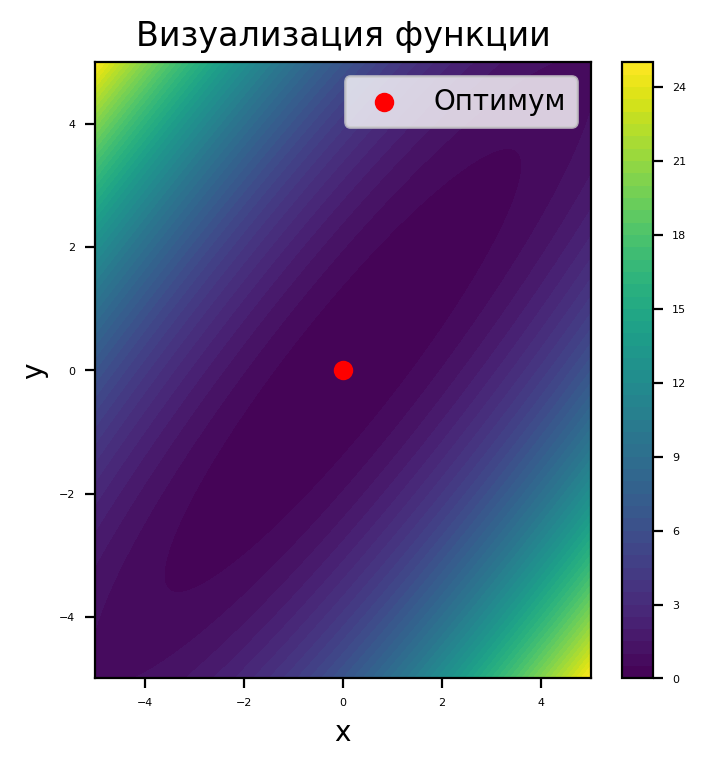

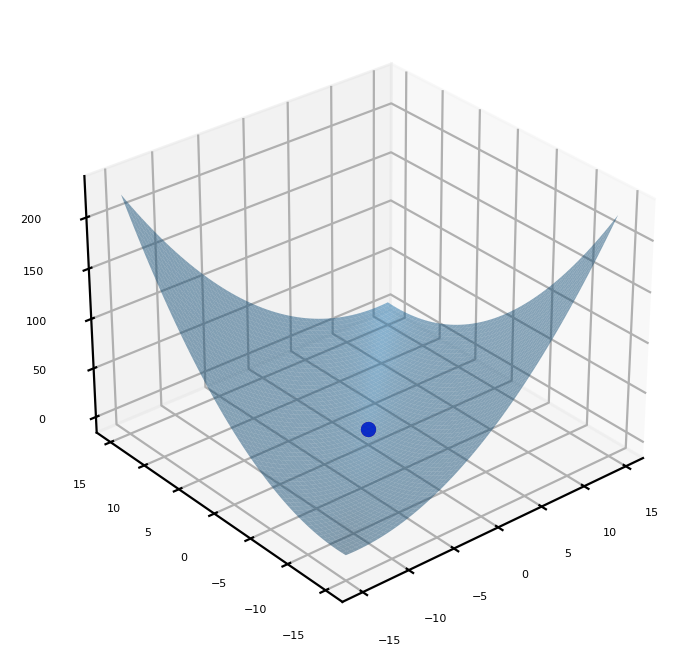

In [247]:
true_minimum_2 = np.array([0, 0])
initial_point = [5, 3]

pipeline(GradientDescent, initial_point, true_minimum_2, test_function_2, count_err, sym_test_gradient_2, False)
pipeline(GradientDescent, initial_point, true_minimum_2, test_function_2, count_err, num_test_gradient_2)

Тестирование MomentumGradientDescent...
Найденный минимум: [-8.97412155e-06 -5.65300377e-06], Ошибка: 1.0606192022798913e-05


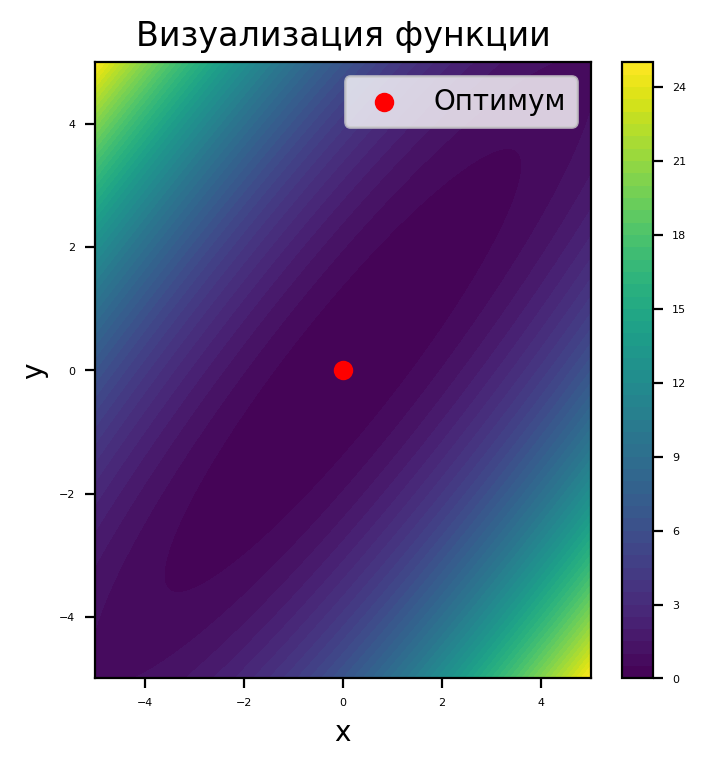

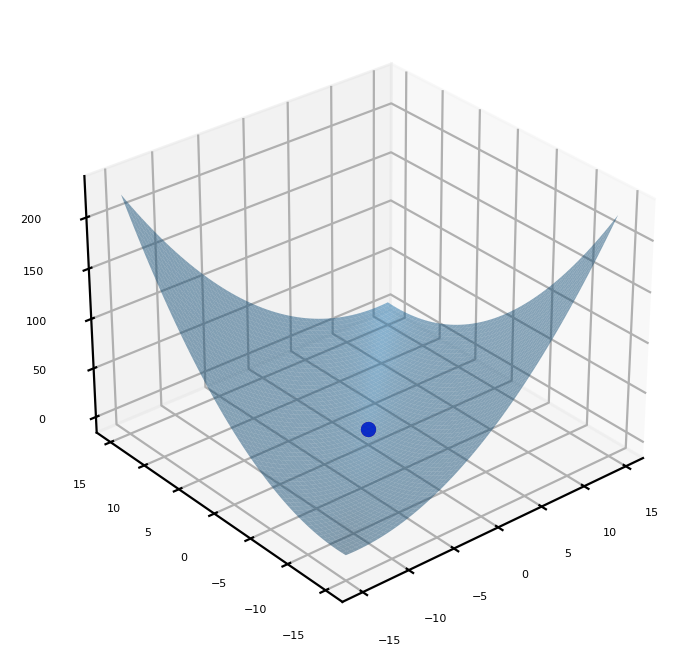

In [128]:
pipeline(MomentumGradientDescent, initial_point, true_minimum_2, test_function_2, count_err, num_test_gradient_2)

Тестирование AdaGrad...
Найденный минимум: [0.05417364 0.05262105], Ошибка: 0.07552322853282609
Тестирование AdaGrad...
Найденный минимум: [0.05417364 0.05262105], Ошибка: 0.07552322852894214


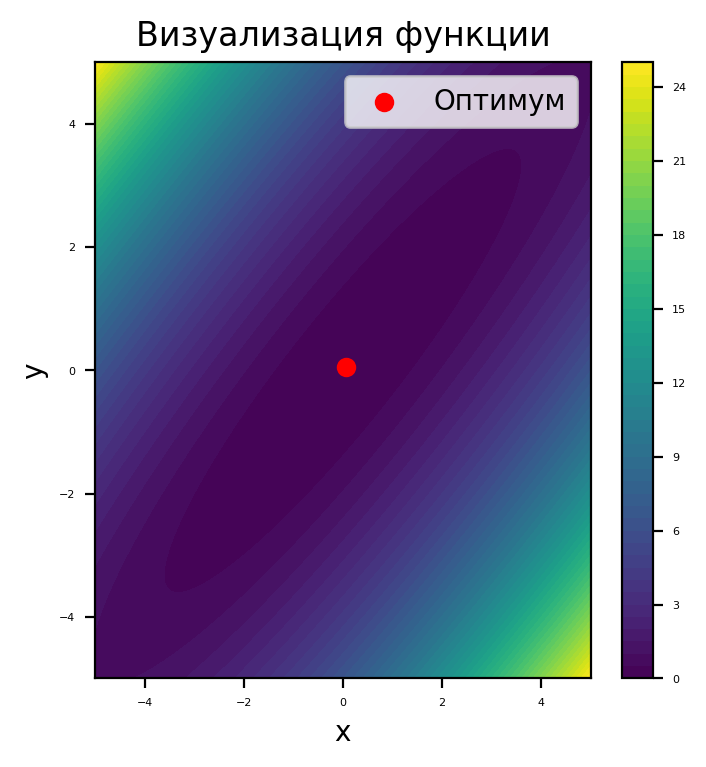

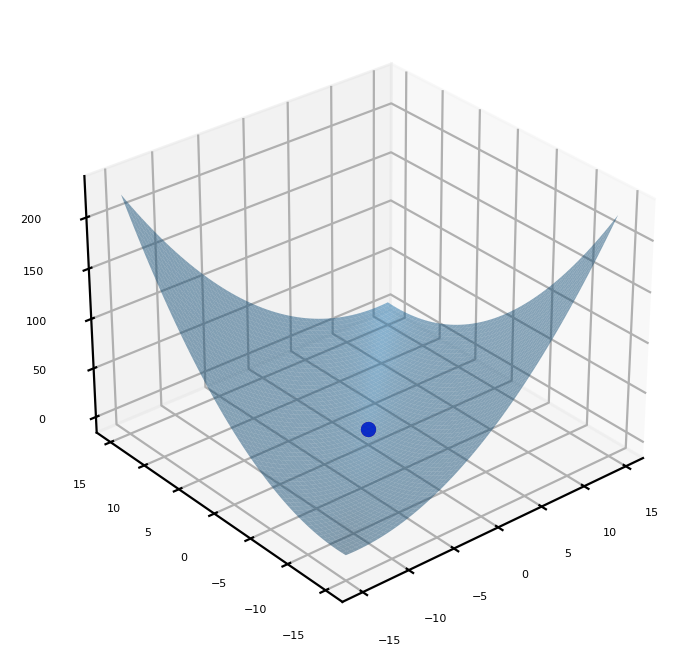

In [248]:
pipeline(AdaGrad, initial_point, true_minimum_2, test_function_2, count_err, sym_test_gradient_2, False)
pipeline(AdaGrad, initial_point, true_minimum_2, test_function_2, count_err, num_test_gradient_2)